In [1]:
# Load libraries
import pandas as pd
import numpy as np
from numpy import arange
from matplotlib import pyplot
from pandas import read_csv
from pandas import set_option
from pandas.tools.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

In [2]:
# Gather some features
def build_features(features, data):
    # remove NaNs
    data.fillna(0, inplace=True)
    data.loc[data.Open.isnull(), 'Open'] = 1
    # Use some properties directly
    features.extend(['Store', 'CompetitionDistance', 'Promo', 'Promo2', 'SchoolHoliday'])

    # Label encode some features
    features.extend(['StoreType', 'Assortment', 'StateHoliday'])
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)

    features.extend(['DayOfWeek', 'Month', 'Day', 'Year', 'WeekOfYear'])
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear

   
    features.append('CompetitionOpen')
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + \
        (data.Month - data.CompetitionOpenSinceMonth)
   
    features.append('PromoOpen')
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + \
        (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    data.loc[data.Promo2SinceYear == 0, 'PromoOpen'] = 0

   
    features.append('IsPromoMonth')
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1

    return data

## Start of main script


In [3]:
print("Load the training, test and store data using pandas")
types = {'CompetitionOpenSinceYear': np.dtype(int),
         'CompetitionOpenSinceMonth': np.dtype(int),
         'StateHoliday': np.dtype(str),
         'Promo2SinceWeek': np.dtype(int),
         'SchoolHoliday': np.dtype(int),
         'PromoInterval': np.dtype(str)}
train = pd.read_csv("train.csv", parse_dates=[2], dtype=types)
test = pd.read_csv("test.csv", parse_dates=[3], dtype=types)
store = pd.read_csv("store.csv")

print("Assume store open, if not provided")
test.fillna(1, inplace=True)

print("Consider only open stores for training. Closed stores wont count into the score.")
train = train[train["Open"] != 0]
print("Use only Sales bigger then zero")
train = train[train["Sales"] > 0]

print("Join with store")
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')

features = []

print("augment features")
train = build_features(features, train)
test = build_features([], test)
print(features)

print('training data processed')

def rmspe(y, yhat):
    return np.sqrt(np.mean(((y - yhat)/y) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y, yhat)

Load the training, test and store data using pandas
Assume store open, if not provided
Consider only open stores for training. Closed stores wont count into the score.
Use only Sales bigger then zero
Join with store
augment features
['Store', 'CompetitionDistance', 'Promo', 'Promo2', 'SchoolHoliday', 'StoreType', 'Assortment', 'StateHoliday', 'DayOfWeek', 'Month', 'Day', 'Year', 'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth']
training data processed


In [4]:
Y=train.Sales
train.drop(['Sales'],axis=1,inplace=True)



In [5]:
train=train[features]
X_train,X_test,Y_train,Y_test=train_test_split(train,Y,test_size=0.2)

In [6]:
print(Y_train[0:5])
Y_train=np.log1p(Y_train)
print(Y_train[0:5])

252820    15597
725114     5363
637373     6219
165100     4788
310270    10297
Name: Sales, dtype: int64
252820    9.654898
725114    8.587465
637373    8.735525
165100    8.474077
310270    9.239705
Name: Sales, dtype: float64


In [7]:
# Spot-Check Algorithms
models = []
models.append(( ' LR ' , LinearRegression()))
models.append(( ' LASSO ' , Lasso()))
models.append(( ' EN ' , ElasticNet()))
models.append(( ' KNN ' , KNeighborsRegressor()))
models.append(( ' CART ' , DecisionTreeRegressor()))
result=[]
for name,model in models:
    lr=model
    lr.fit(X_train,Y_train)
    y_pred=lr.predict(X_test)
    y_pred=np.expm1(y_pred)
    result.append((name,rmspe(Y_test,y_pred)))
for name,ans in result:
    print(name+" "+str(ans))

 LR  0.530418186855
 LASSO  0.6358038029
 EN  0.635787393892
 KNN  0.461518399202
 CART  0.325826420664


In [8]:
lr=RandomForestRegressor()
lr.fit(X_train,Y_train)
y_pred=lr.predict(X_test)
ans=rmspe(np.expm1(y_pred),Y_test)
print("RandomForestRegressor"+" "+str(ans))


RandomForestRegressor 0.136547145056


In [9]:
est=[5,10,15,20,25,30]
for i in est:
    lr=RandomForestRegressor(n_estimators=i)
    lr.fit(X_train,Y_train)
    y_pred=lr.predict(X_test)
    ans=rmspe(np.expm1(y_pred),Y_test)
    print("RandomForestRegressor with"+str(i)+"Estimators"+" "+str(ans))

RandomForestRegressor with5Estimators 0.144431348346
RandomForestRegressor with10Estimators 0.135952035852
RandomForestRegressor with15Estimators 0.133013944832
RandomForestRegressor with20Estimators 0.131554250762
RandomForestRegressor with25Estimators 0.13082762112
RandomForestRegressor with30Estimators 0.130806254077


In [10]:
est=[35,50,100]
for i in est:
    lr=RandomForestRegressor(n_estimators=i)
    lr.fit(X_train,Y_train)
    y_pred=lr.predict(X_test)
    ans=rmspe(np.expm1(y_pred),Y_test)
    print("RandomForestRegressor with"+str(i)+"Estimators"+" "+str(ans))

RandomForestRegressor with35Estimators 0.129937273564
RandomForestRegressor with50Estimators 0.128750307941
RandomForestRegressor with100Estimators 0.128178656706


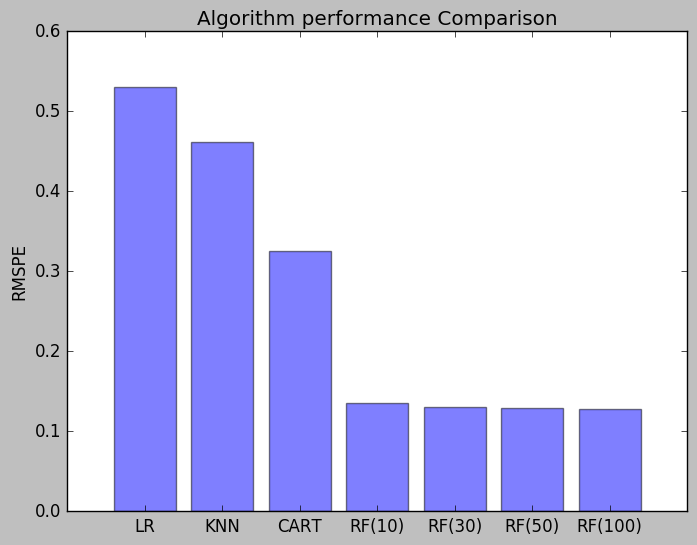

In [30]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = ('LR', 'KNN', 'CART', 'RF(10)', 'RF(30)', 'RF(50)','RF(100)')
y_pos = np.arange(len(objects))
performance = [0.53041,0.46151,0.32582,0.13595,0.13080,0.12874,0.12817]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('RMSPE')
plt.title('Algorithm performance Comparison')
 
plt.show()